This notebook presents the **AI25** traffic model built in [SUMO](https://sumo.dlr.de/docs/index.html).

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoData, LayersControl, Choropleth, GeoJSON
from branca.colormap import linear
import json

In [3]:
import sys, os
# add sumo tools to path to continue imports
if "SUMO_HOME" in os.environ:
	sumotools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(sumotools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

import sumolib

# add local sumo_processing directory
sumoproc = os.path.join(os.getcwd(), '../../data-processing/')
sys.path.append(sumoproc)

import sumo_processing

# AI25 Traffic Model
The **AI25** traffic model is a 24-hour microsimulation model of projected 2025 vehicle traffic on Aquidneck Island in Rhode Island, USA.  It uses the *Aquidneck Island Transport* SUMO network model and annual average daily traffic demand data provided by the State of Rhode Island.  The purpose of the model is to examine the flow in the network and establish baseline performance.

## Aquidneck Island Network Model
The transportation network model is based on OpenStreetMap data, and refined using SUMO's NETEDIT tool based on local surveys and observations. *[insert link to network documentation]*

In [4]:
net = sumolib.net.readNet('../aquidneck_island.net.xml')

In [5]:
# convert sumolib Net to a GeoDataFrame for further processing
net_edges = sumo_processing.net_edges_to_geodataframe(net)
net_edges.index = net_edges['edge_id']

In [13]:
net_edges.index.name = 'id'

### AI25 Network Features
Some features were added to the Aquidneck Island Transport network model to 1) improve the realism of traffic features and 2) improve execution of the simulation.
#### Naval Station Newport Gates
* Router weights - router edge weighting added to all base entrances to reflect the restricted access on the base and discourage cut through traffic
* Gate closures - road closure rerouting devices are placed in the vicinity to send traffic around gates during hours they are closed.
* Gate processing speeds - reduced speeds at the gate entrances simulate the security processing time and allow queues to form during peak hours.

## AI25 Demand Model
The traffic demand is based on projected 2025 origin-destination (OD) data used in the Rhode Island State Highway Model. The total traffic demand was generated from matrices of OD flow between traffic analysis zones (TAZ).  Four trip-types were factored into the demand:
* Home-based work auto (*hbwauto25*) - car traffic generated by traveling between home and work.
* Home-based non-work auto (*hbnwauto25*) - car traffic generated by traveling between home and destinations other than work (excluding legs of a multimodal trip, e.g. drive to train station)
* Non-home-based (*nhbauto25*) - car traffic between points not including home, such as work errands.
* Trucks (*truck25*) - truck traffic

Traffic from points off-island is consolidated into three bridge TAZs in the state OD data.

In [6]:
# interactive model map - use jupyter or https://nbviewer.jupyter.org/ to view.
geo_data = GeoData(geo_dataframe = net_edges.to_crs(epsg=4326), 
                   style={'color':'blue', 'weight':1, 'opacity':1}, 
                   name='network')
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.Positron)
#m.add_layer(geo_data)
#m.add_layer(dark_matter_layer)
m = Map(center=(41.55, -71.3), zoom=11, scroll_wheel_zoom=True, layers=(geo_data, dark_matter_layer))
m

Map(center=[41.55, -71.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

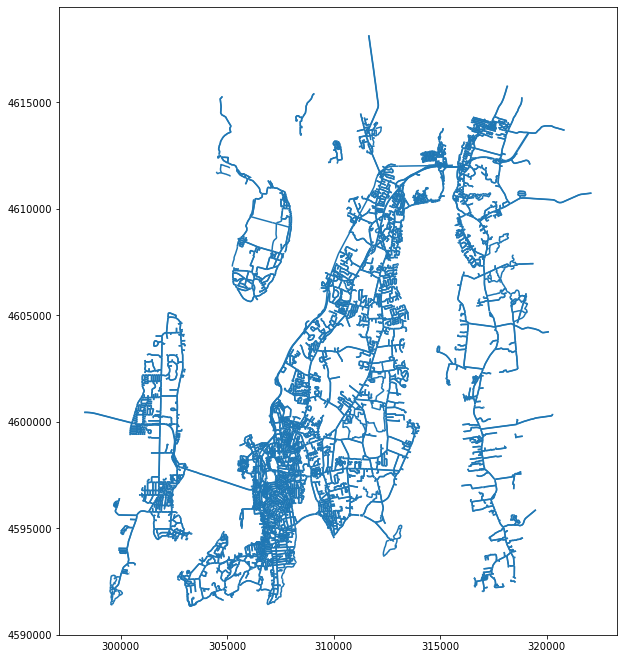

In [7]:
net_edges.plot(figsize=[10,15])

# Simulation Results

Simulation data were captured using 'summary' and 'tripinfo' output options, as well as hourly edge traffic and emissions measurements.  The data were collected for each run.  Some runs terminated early.  Data were converted to csv using the `xml2csv.py` tool included with python.

In [8]:
# load simulation run data  
# This would typically be the output sub-directory in the simulation directory - adjust folder names to match sumocfg files

data_folder = '../../aquidneck-model-datafiles/ai25/'

summary_data = pd.DataFrame()
tripinfo_data = pd.DataFrame()
traffic_data = pd.DataFrame()
emissions_data = pd.DataFrame()

for run in range(0,10):
    run_folder = data_folder + 'run%s/' % str(run)
    
    # build summary dataframe
    summary = pd.read_csv(run_folder+'ai_simulation_summary.csv', sep=';')
    summary.index.name = 'step'
    summary['run'] = run
    summary_data = summary_data.append(summary, sort=False)
    
    # build tripinfos
    tripinfo = pd.read_csv(run_folder+'ai_simulation_tripinfo.csv', sep=';')
    tripinfo['run'] = run
    tripinfo_data = tripinfo_data.append(tripinfo, sort=False)
    print(run_folder)
    
    # traffic data
    traffic = pd.read_csv(run_folder+'hourly_edge_traffic_data.csv', sep=';')
    traffic['run'] = run
    traffic_data = traffic_data.append(traffic, sort=False)
    
    # emissions data
    emissions = pd.read_csv(run_folder+'hourly_edge_emissions_data.csv', sep=';')
    emissions['run'] = run
    emissions_data = emissions_data.append(emissions, sort=False)

../../aquidneck-model-datafiles/ai25/run0/
../../aquidneck-model-datafiles/ai25/run1/
../../aquidneck-model-datafiles/ai25/run2/
../../aquidneck-model-datafiles/ai25/run3/
../../aquidneck-model-datafiles/ai25/run4/
../../aquidneck-model-datafiles/ai25/run5/
../../aquidneck-model-datafiles/ai25/run6/
../../aquidneck-model-datafiles/ai25/run7/
../../aquidneck-model-datafiles/ai25/run8/
../../aquidneck-model-datafiles/ai25/run9/


Traffic demand is scaled throughout the day.  Home-based work traffic timing was loosely based on American Community Survey 2017 5-Year estimate data.  Other timing was estimated.

`step_running` count is the total number of vehicles traveling on the network.  `step_halting` is the number of those running vehicles that are halted in traffic, including stop lights, yielding, and traffic jams.

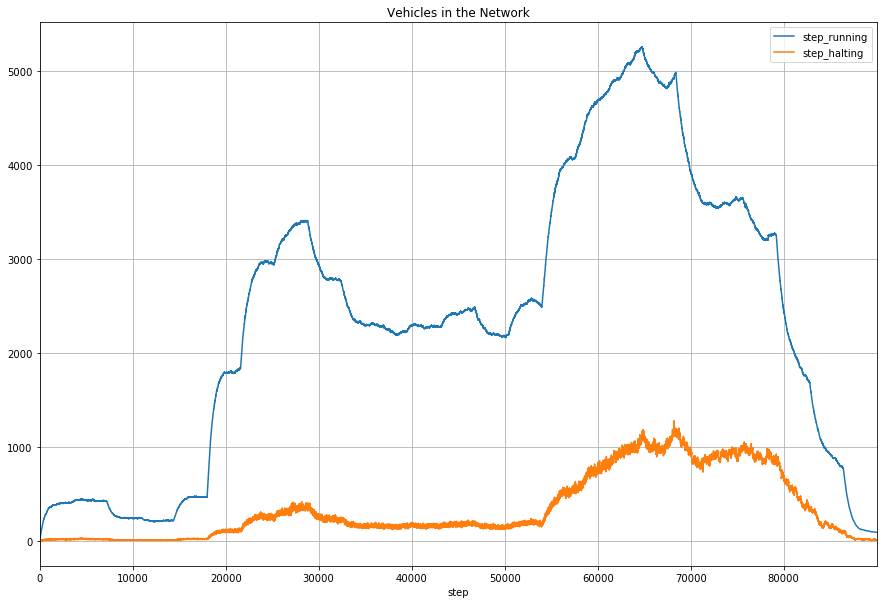

In [10]:
summary_data.groupby('step')[
    ['step_running','step_halting']
].mean().plot(title='Vehicles in the Network', figsize=[15,10], grid=True)
plt.show()

In [11]:
# build map of hourly traffic averaged over runs
traffic_data_meaned = traffic_data.groupby(['edge_id','interval_begin'], as_index=False).mean()
hourly_traffic_data = traffic_data_meaned.groupby('interval_begin')

# convert edges to geojson polygons for display
net_edge_json = json.loads(net_edges.buffer(5).to_crs(epsg=4326).to_json())

Traffic counts on streets is measured by the `edge_left` metric in the `traffic` data.  This includes all vehicles that exited the edge.  The map below plots binned edge traffic counts for 8am, averaged across the 10 simulation runs.

In [9]:
# layer = Choropleth(
#     geo_data=net_edge_json,
#     choro_data=dict(hourly_traffic_data.get_group(28800)[['edge_id', 'edge_left']].values.tolist()),
#     colormap=linear.YlOrRd_06,
#     value_min=0.0,
#     value_max=100,
#     style={'fillOpacity':1, 'weight':0}
# )

In [10]:
# traffic_map = Map(center=(41.50, -71.31), zoom=15, scroll_wheel_zoom=True)
# traffic_map.add_layer(basemap_to_tiles(basemaps.Stamen.Toner))
# traffic_map.add_layer(layer)
# traffic_map

Map(center=[41.5, -71.31], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

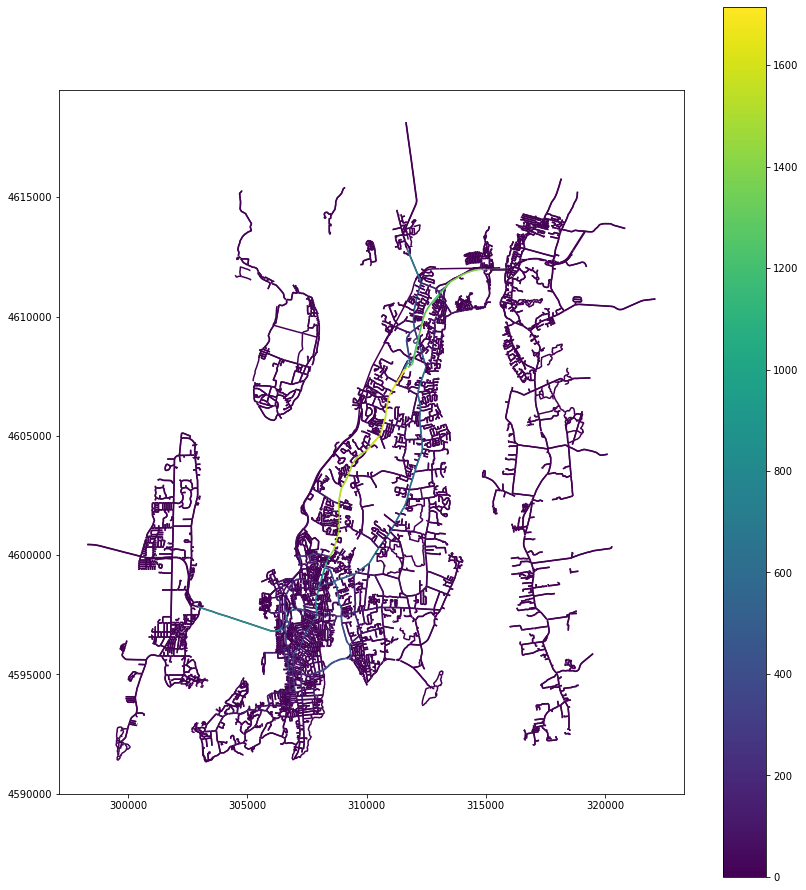

In [26]:
net_edges.merge(traffic_data_meaned, on='edge_id').groupby('interval_begin').get_group(28800).plot('edge_left', figsize=[14,16], legend='best')

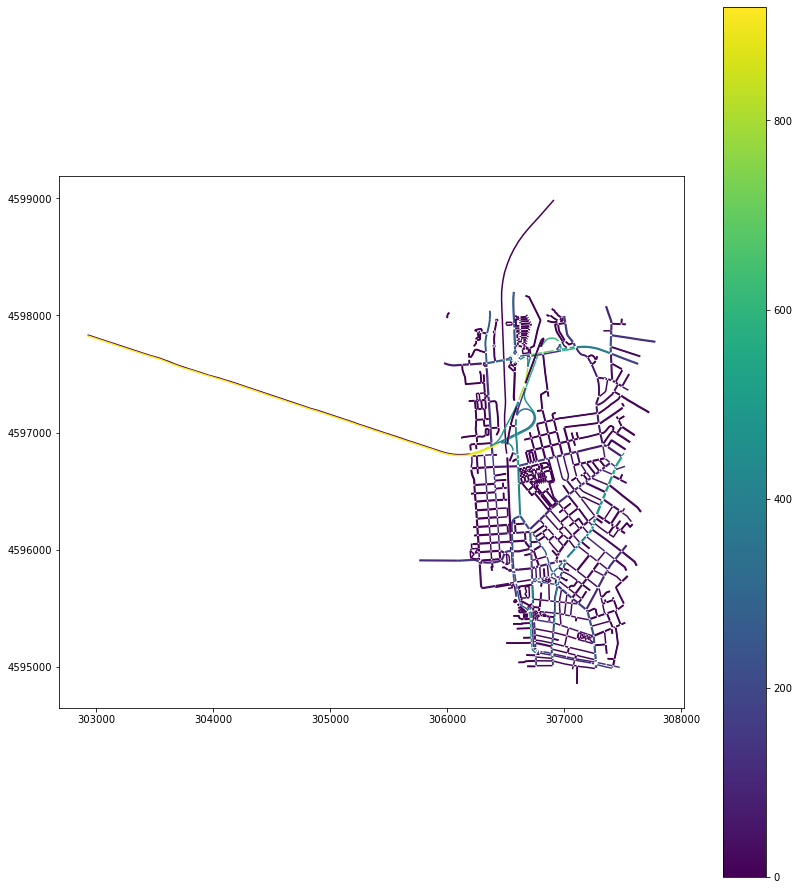

In [21]:
# zoomed in
net_edges.merge(traffic_data_meaned, on='edge_id').groupby('interval_begin').get_group(28800).cx[306000:307500,4595000:4598000].plot('edge_left', figsize=[14,16], legend='best')